In [2]:

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import random as rd
import cv2
import gc
import random


!pip install wfdb
import wfdb

     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 163kB 39.7MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=f9be9c7a731fc618bb8e536f8df498c7d66a7c1f6ad0a2b2f1859d48cf9ffc24
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


In [3]:
!git clone https://github.com/AlexandrePerdereau/pfeECG.git

Cloning into 'pfeECG'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 737 (delta 7), reused 16 (delta 4), pack-reused 718
Receiving objects: 100% (737/737), 74.92 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [0]:
directory = 'pfeECG/mit-bih-arrhythmia-database-1.0.0/'
file = open(directory + 'RECORDS')
records = file.readlines()
file.close()

In [5]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [0]:
good = ['N']
leftBundleBlocks = ['L']
rightBundleBlocks = ['R']
atrialContraction = ['A']
ventricularContraction = ['V']
paced = ['/']
ventricularEscape = ['E']
ventricularFlutterWave = ['!']

In [0]:
def segmentation(typeBeat):

    liste1,liste2 = [],[]

    for e in records:
        signals, fields = wfdb.rdsamp(directory + e[0:-1]) 

        ann = wfdb.rdann(directory + e[0:-1], 'atr')
       
        ids = np.in1d(ann.symbol, typeBeat)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in imp_beats:
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                x = beats[j-1]
                y = beats[j+1]
                diff1 = abs(x - beats[j])//2
                diff2 = abs(y - beats[j])//2
                signal0 = signals[beats[j] - diff1: beats[j] + diff2, 0]
                signal1 = signals[beats[j] - diff1: beats[j] + diff2, 1]
                
                #indMax = signal0.index(np.max(np.abs(signal0)))
                indMax = np.where(np.abs(signal0) == np.max(np.abs(signal0)))
                indMid = int(len(signal0)//2)
                shift = indMax[0] - indMid
                
                signal0 = np.roll(signal0, -shift)
                signal1 = np.roll(signal1, -shift)
                
                
                if (len(signal0) < 501):
                    signal0Pad = padding(signal0,500)
                    signal1Pad= padding(signal1,500)
                else:
                    signal0Pad = signal0
                    signal1Pad = signal1
                #print(shift)
                #if shift > 0:
                 #   signal0 = np.roll(signal0, -shift)
                #elif shift < 0:
                 #   signal0 = np.roll(signal0, -shift)
                
                liste1.append(signal0Pad)
                liste2.append(signal1Pad)

    #liste1 = liste1[1:] 
    #liste2 = liste2[1:]
    return liste1,liste2

In [0]:
def padding(signal0,lmax):
    length = len(signal0)
    shift = (lmax - length)//2
    signalPadded = np.pad(signal0, (shift, shift), 'constant')
    return signalPadded

In [0]:
class ECGDataset(Dataset):

    def __init__(self, Dir):
        
        file = open(Dir+'RECORDS')
        records = file.readlines()
        file.close()
        
        good = ['N']
        leftBundleBlocks = ['L']
        rightBundleBlocks = ['R']
        atrialContraction = ['A']
        ventricularContraction = ['V']
        paced = ['/']
        ventricularEscape = ['E']
       # ventricularFlutterWave = ['!']
        
        NORMAL = segmentation(good)
        random.shuffle(NORMAL[0])
        random.shuffle(NORMAL[1])
        normal0 = NORMAL[0][0:10000]
        normal1 = NORMAL[1][0:10000]
        NORMAL = (normal0,normal1)
        LBB = segmentation(leftBundleBlocks)
        RBB = segmentation(rightBundleBlocks)
        APC = segmentation(atrialContraction)
        PVC = segmentation(ventricularContraction)
        VEB = segmentation(ventricularEscape)
        PAB = segmentation(paced)
        #VFW = segmentation(ventricularFlutterWave)
        
        
        NORMALLabel = ['Normal']*len(NORMAL[0])
        LBBLabel = ['LBB']*len(LBB[0])
        RBBLabel = ['RBB']*len(RBB[0])
        APCLabel = ['APC']*len(APC[0])
        PVCLabel = ['PVC']*len(PVC[0])
        VEBLabel = ['VEB']*len(VEB[0])
        PABLabel = ['PAB']*len(PAB[0])
       # VFWLabel = ['VFW']*len(VFW[0])

        self.Labels =np.array(NORMALLabel + LBBLabel + RBBLabel + APCLabel + PVCLabel + VEBLabel + PABLabel )
        self.Signals =  np.concatenate((NORMAL, LBB, RBB, APC, PVC, VEB, PAB),axis = 1)

        
        
        
        

    def __len__(self):
        return len(self.Signals[0])

    def __getitem__(self, idx):

        sample = {'Signals': self.Signals[:,idx], 'Label': self.Labels[idx]}

        return sample
    
    
    

In [0]:
DS = ECGDataset(Dir = directory)
sample = DS[0]

In [11]:
len(DS)

42132

In [0]:
tailles = []
for sample in DS:
    longueur = len(sample['Signals'][0])
    
    if not np.any(tailles == longueur) and longueur <= 1000:
        tailles.append(longueur)
        
tailleMax = np.max(tailles)
indexMax = np.argmax(tailles)
    

'PAB'

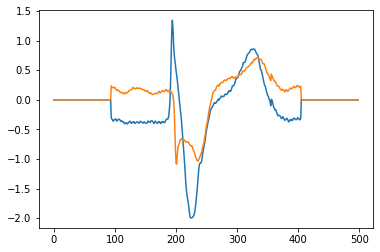

In [13]:

plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [0]:
def normalize(DS):
    for sample in DS:
        sample['Signals'][0] = sample['Signals'][0][int(len(sample['Signals'][0]) /2)-100:int(len(sample['Signals'][0]) /2)+100]
        sample['Signals'][1] = sample['Signals'][1][int(len(sample['Signals'][1]) /2)-100:int(len(sample['Signals'][1]) /2)+100]
        #print(len(sample['Signals'][0]))
    return DS

DS = normalize(DS)

'LBB'

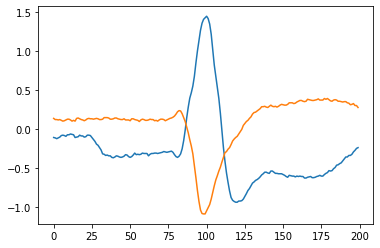

In [15]:

sample = DS[10080]
plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [0]:
class subDataSet(Dataset):
    def __init__(self, sampleList):
        
        

        self.samples = sampleList

 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        sample = {'Signals': self.samples['Signals'][idx], 'Label': self.samples['Label'][idx]}

        return sample
    

In [0]:
def createSubDataSets(trainproportion,totalDataSet):
    train = []
    test = []
    for sample in DS:
        rand = rd.random()
        if (rand < trainproportion):
            train.append(sample)
        else:
            test.append(sample)
    trainSet = subDataSet(train)
    testSet = subDataSet(test)
    return trainSet, testSet

    

In [0]:
trainSet, testSet = createSubDataSets(0.70, DS)

In [19]:
len(trainSet), len(testSet) , len(DS)
#plt.plot(sample['Signals'][0])
#plt.plot(sample['Signals'][1])
#sample['Label']

(29613, 12519, 42132)

In [0]:
# Transformation en image


def signals2Images(DS,label):
    
   
    count = 0

    for sample in DS:
      if sample['Label'] == label:
        fig = plt.figure(frameon=False) 
        plt.plot(sample['Signals'][0])
        plt.plot(sample['Signals'][1])
        plt.xticks([]), plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        
                 
        filename = 'pfeECG/images' + '/' + label + '/' + str(count)+'.png'
        fig.savefig(filename)
        im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        im_gray = cv2.resize(im_gray, (128, 128), interpolation = cv2.INTER_LANCZOS4)
        cv2.imwrite(filename, im_gray)
        count = count + 1
        print(count)
        plt.close()
        
        
path = "pfeECG/images/" + 'Normal'
os.makedirs(path)
signals2Images(DS,'Normal')
gc.collect()
path = "pfeECG/images/" + 'LBB'
os.makedirs(path)
signals2Images(DS,'LBB')
gc.collect()
path = "pfeECG/images/" + 'RBB'
os.makedirs(path)
signals2Images(DS,'RBB')
gc.collect()
path = "pfeECG/images/" + 'APC'
os.makedirs(path)
signals2Images(DS,'APC')
gc.collect()
path = "pfeECG/images/" + 'PVC'
os.makedirs(path)
signals2Images(DS,'PVC')
gc.collect()
path = "pfeECG/images/" + 'VEB'
os.makedirs(path)
signals2Images(DS,'VEB')
gc.collect()
path = "pfeECG/images/" + 'PAB'
os.makedirs(path)
signals2Images(DS,'PAB')
gc.collect()

        


In [0]:
path = "pfeECG/images/" + 'LBB'
os.makedirs(path)
signals2Images(DS,'LBB')

In [22]:
gc.collect()

13940835

In [0]:
path = "pfeECG/images/" + 'RBB'
os.makedirs(path)
signals2Images(DS,'RBB')

In [0]:
path = "pfeECG/images/" + 'APC'
os.makedirs(path)
signals2Images(DS,'APC')

In [0]:
path = "pfeECG/images/" + 'PVC'
os.makedirs(path)
signals2Images(DS,'PVC')

In [0]:
path = "pfeECG/images/" + 'VEB'
os.makedirs(path)
signals2Images(DS,'VEB')

In [0]:
path = "pfeECG/images/" + 'PAB'
os.makedirs(path)
signals2Images(DS,'PAB')

In [0]:
path = "pfeECG/images/" + 'Normal'
os.makedirs(path)
signals2Images(DS,'Normal')